In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

# CHEM 277B - HW 8: Convolutional Neural Networks

## 1. Convolutional Neural Networks Applied to Classification ##

We will
again use the MNIST data set to train, validation, and test but this time
using a CNN. As described in lecture, 2D convolutional neural nets are
specified by various hyperparameters: a receptive field (filter size,
DxWxH), number of filters K, stride S, amount of zero padding P, and
type of pooling. We will represent our input data, as well as the hidden
layers, as 3D-arrays. Since MNIST images are black-and-white and thus
have scalar-valued pixels, the depth of the input image is 1.

## (a) ##

Calculate the dimensionality of the output for the following
convolutions sequentially applied to a black and white MNIST input:

$$
H_{\text {out }}=\left[\frac{H_{\text {in }}+2 \times \text { padding }-\text { filter size }}{\text { stride }}+1\right]
$$

### (i) ###

Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0

In [2]:
mnist = pd.read_pickle('../Datasets/mnist.pkl')
mnist[0][0].shape

(60000, 32, 32)

The dimensions of the input is 32 x 32. Therefore,

$$
H_{\text {out }}=\left[\frac{32+2 \times 0 - 2}{2}+1\right] = 16
$$

Since the input image is a square, the width and height will both be 16. The depth will be the number of filters, which is 33. Therefore, the output will be **16 x 16 x 33**

<br>

### (ii) ###

Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1

$$
H_{\text {out }}=\left[\frac{16+2 \times 1 - 3}{1}+1\right] = 16
$$

The output will be **16 x 16 x 55**

<br>

### (iii) ### 
Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max
Pooling with filter size of 2x2 and stride 2

$$
H_{\text {out }}=\left[\frac{16+2 \times 1 - 3}{1}+1\right] = 16
$$

<br>

<center> Before max pooling: $(16, 16, 77)$ <center>

<br>

$$
H_{\text {pool out }}=\left[\frac{16 - 2}{2}+1\right] = 8
$$

$$ (8, 8, 77) $$

The output will be **8 x 8 x 77**
    
<br>

## (b) ##

The MNIST data set was, in fact, in color (RGB). This means the depth of the input image would
be 3. Calculate the dimensionality of the output for the following convolutions sequentially applied to a
RGB MNIST input:

### (i) ### 
Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0

Because the filter's depth should match the input dimension for the 2D convolutional layer, the filter depth is now 3 to match with a colored input image. 

$$
H_{\text {out }}=\left[\frac{32+2 \times 0 - 2}{2}+1\right] = 16
$$

Although the depth of the input image has increased from 1 to 3, because the filter depth also increased to match the new input, the output will be **16 x 16 x 33** because 33 filters are applied to the input.

<br>



### (ii) ###

Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1. Followed by a max pooling layer of kernel size 3x3, stride of 1, padding of 0

$$
H_{\text {out }}=\left[\frac{16+2 \times 1 - 3}{1}+1\right] = 16
$$

<br>

<center> Before max pooling: $(16, 16, 55)$ <center>

<br>
    
$$
H_{\text {pool out }}=\left[\frac{16 - 3}{1}+1\right] = 14
$$

$$ (14, 14, 55) $$
    
The output will be **14 x 14 x 55**
    
<br>

### (iii) ###

Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max
Pooling with filter size of 2x2 and stride 2.

$$
H_{\text {out }}=\left[\frac{14+2 \times 1 - 3}{1}+1\right] = 14
$$

<br>

<center> Before max pooling: $(14, 14, 77)$ <center>

<br>

$$
H_{\text {pool out }}=\left[\frac{14 - 2}{2}+1\right] = 7
$$

$$ (7, 7, 77) $$

The output will be **7 x 7 x 77**
    
<br>

## (c) ##

Next, implement a CNN to see if we can extract additional features from the MNIST data. For this
start with one convolutional layer with a 5x5 kernel, with stride of 1, zero-padding of size 2, and 3 output
channels. Flatten the resulting feature maps and add a second layer of fully connected (FC) layer to the 10-
neuron output layer. Use ReLU as your activation function. Use the ADAM optimizer with learning rate of
1e-3, batchsize of 128, and 30 epochs (you can also train for longer if time permits). Use mini-batches of
data and converge your training to where the loss function is minimal, and choose some regularization
techniques. Using 3-fold cross-validation and report your average test accuracy

In [3]:
from torch import nn
import torch 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(1, 3, kernel_size=5, stride=1, padding=2) #(N, 1, 32, 32)
        self.fc = nn.Linear(3*32*32, 10)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.conv(x)
        x = self.activation(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [4]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [5]:
def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to torch tensors ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + l2_lambda * l2_norm
                ### Backpropagation ###
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item() * batch_importance
                pred = torch.argmax(batch_predictions, axis=-1)
                acc = torch.sum(pred == batch_output) / len(batch_output)
                epoch_acc += acc.detach().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 == 0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, 
                                                                epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, 
                "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        ### convert data to torch tensors ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        
        self.model.eval() 
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute predictions and loss ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            pred = torch.argmax(batch_predictions, axis=-1)
            batch_acc = torch.sum(pred == batch_output) / len(batch_output)
            losses += loss.detach().item() * batch_importance
            acc += batch_acc.detach().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [6]:
from sklearn.model_selection import KFold
# KFold Cross Validation
def Kfold(k, input, output, l2=False):
    kf = KFold(n_splits=k, shuffle=True)

    train_error_all = []
    val_error_all = []
    train_acc_all = []
    val_acc_all = []

    for train_index, val_index in kf.split(input):
        train_input, val_input = input[train_index], input[val_index]
        train_output, val_output = output[train_index], output[val_index]
        
        mnist_cnn = CNN()
        cnn_trainer = Trainer(mnist_cnn, optimizer_type='adam', learning_rate=1e-3, epoch=30, 
                                batch_size=128)

        log = cnn_trainer.train(train_input, train_output, val_input, val_output)
        train_error_all.append(log['losses'][-1])
        val_error_all.append(log['val_losses'][-1])
        train_acc_all.append(log['accuracies'][-1])
        val_acc_all.append(log['val_accuracies'][-1])

        # From log, find the best epoch
        print('Epoch with lowest validation loss: %d' % (np.argmin(log['val_losses']) + 1))
        print('Epoch with highest validation accuracy: %d' % (np.argmax(log['val_accuracies']) + 1))

        # Plot training and validation loss
        plt.plot(log['losses'], label='Training Loss')
        plt.plot(log['val_losses'], label='Validation Loss')
        # Title the current fold number
        plt.title('Training and Validation Loss for Fold %d' % len(train_error_all))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot training and validation accuracy
        plt.plot(log['accuracies'], label='Training Accuracy')
        plt.plot(log['val_accuracies'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy for Fold %d' % len(train_error_all))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

    print('Average training accuracy: %.3f' % np.mean(train_acc_all))
    print('Average testing accuracy: %.3f' % np.mean(val_acc_all))

  3%|█▍                                          | 1/30 [00:03<01:41,  3.51s/it]

Epoch 1/30 - Loss: 1.927 - Acc: 0.534
              Val_loss: 1.884 - Val_acc: 0.576


 37%|███████████████▊                           | 11/30 [00:34<00:56,  2.95s/it]

Epoch 11/30 - Loss: 1.794 - Acc: 0.667
              Val_loss: 1.800 - Val_acc: 0.661


 70%|██████████████████████████████             | 21/30 [01:03<00:26,  2.97s/it]

Epoch 21/30 - Loss: 1.708 - Acc: 0.753
              Val_loss: 1.701 - Val_acc: 0.760


func:'train'  took: 89.6324 sec
Epoch with lowest validation loss: 30
Epoch with highest validation accuracy: 30


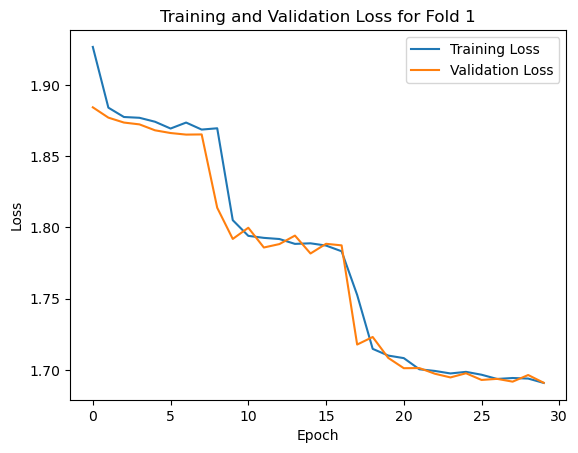

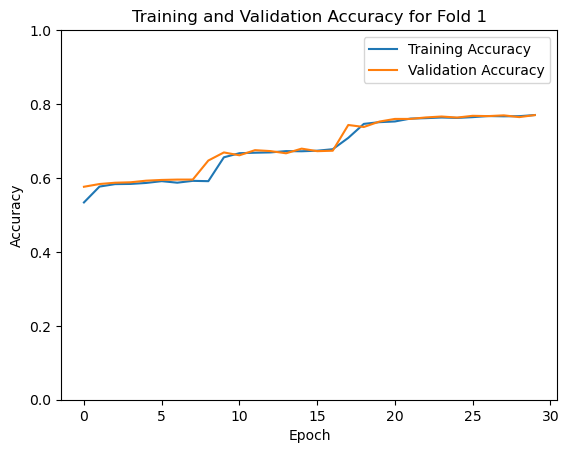

  3%|█▍                                          | 1/30 [00:03<01:38,  3.39s/it]

Epoch 1/30 - Loss: 1.962 - Acc: 0.497
              Val_loss: 1.904 - Val_acc: 0.556


 37%|███████████████▊                           | 11/30 [00:33<00:56,  2.99s/it]

Epoch 11/30 - Loss: 1.625 - Acc: 0.835
              Val_loss: 1.630 - Val_acc: 0.831


 70%|██████████████████████████████             | 21/30 [01:03<00:26,  2.90s/it]

Epoch 21/30 - Loss: 1.612 - Acc: 0.848
              Val_loss: 1.621 - Val_acc: 0.840


func:'train'  took: 89.4913 sec
Epoch with lowest validation loss: 30
Epoch with highest validation accuracy: 30


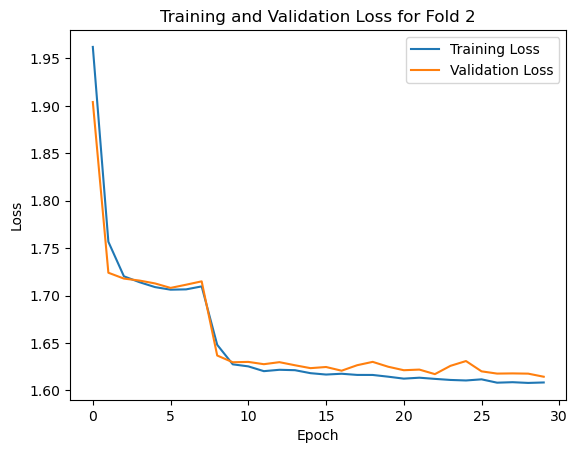

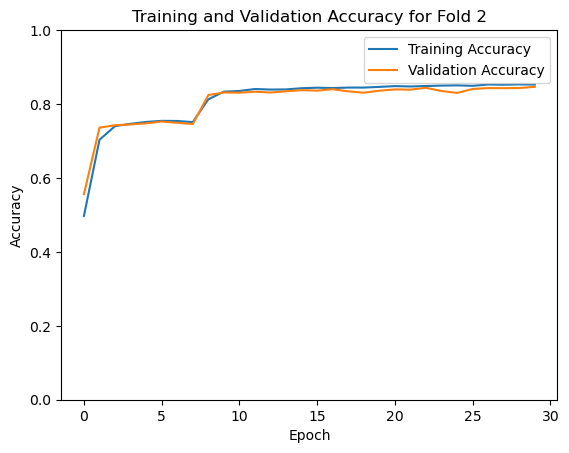

  3%|█▍                                          | 1/30 [00:03<01:29,  3.10s/it]

Epoch 1/30 - Loss: 1.569 - Acc: 0.893
              Val_loss: 1.525 - Val_acc: 0.936


 37%|███████████████▊                           | 11/30 [00:35<00:58,  3.09s/it]

Epoch 11/30 - Loss: 1.492 - Acc: 0.969
              Val_loss: 1.505 - Val_acc: 0.956


 70%|██████████████████████████████             | 21/30 [01:04<00:26,  2.91s/it]

Epoch 21/30 - Loss: 1.489 - Acc: 0.972
              Val_loss: 1.504 - Val_acc: 0.957


func:'train'  took: 89.8831 sec
Epoch with lowest validation loss: 29
Epoch with highest validation accuracy: 29


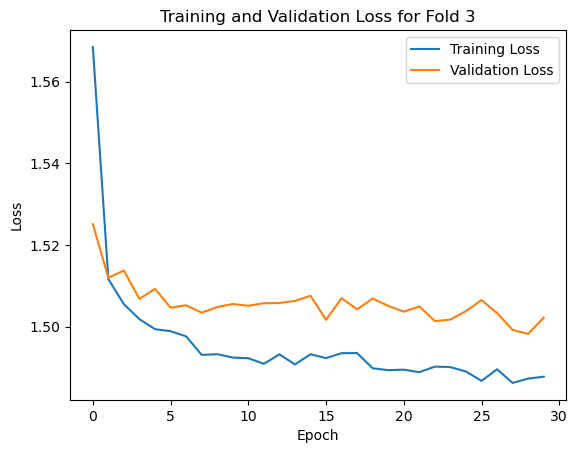

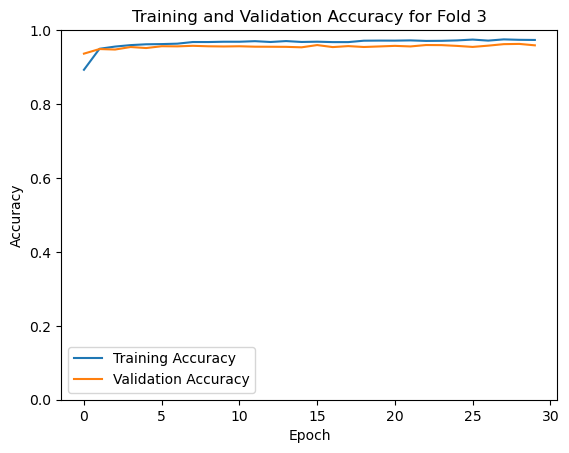

Average training accuracy: 0.865
Average testing accuracy: 0.859


In [7]:
training_data = mnist[0][0] # original training data
training_labels = mnist[0][1] # original training data labels

Kfold(3, training_data, training_labels)

## (d) ##

Now build a deeper (more layers) architecture with two layers each composed of one convolution
and one pooling layer. Flatten the resulting feature maps and use two fully connected (FC) layers. Use
conv/pooling layers that with kernel, stride and padding size of your choice. Use ReLU as your activation
function. Again, use the ADAM optimizer with learning rate of 1e-3, batchsize of 128, and 30 epochs (you
can also train for longer if time permits). Use mini-batches of data and converge your training to where the
loss function is minimal, and choose some regularization techniques. Using 3-fold cross-validation report
and your average test accuracy. You should aim for getting test accuracy above 98.5%.

In [8]:
class Improved_CNN(nn.Module):
    def __init__(self):
        super(Improved_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=2) #(N, 1, 32, 32)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(10*8*8, 100)
        self.fc2 = nn.Linear(100, 10)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [9]:
def Kfold(k, input, output, l2=True):
    kf = KFold(n_splits=k, shuffle=True)

    train_error_all = []
    val_error_all = []
    train_acc_all = []
    val_acc_all = []

    for train_index, val_index in kf.split(input):
        train_input, val_input = input[train_index], input[val_index]
        train_output, val_output = output[train_index], output[val_index]
        
        mnist_cnn = Improved_CNN()
        cnn_trainer = Trainer(mnist_cnn, optimizer_type='adam', learning_rate=1e-3, epoch=30, 
                                batch_size=128)

        log = cnn_trainer.train(train_input, train_output, val_input, val_output, l2=l2)
        train_error_all.append(log['losses'][-1])
        val_error_all.append(log['val_losses'][-1])
        train_acc_all.append(log['accuracies'][-1])
        val_acc_all.append(log['val_accuracies'][-1])

        # From log, find the best epoch
        print('Epoch with lowest validation loss: %d' % (np.argmin(log['val_losses']) + 1))
        print('Epoch with highest validation accuracy: %d' % (np.argmax(log['val_accuracies']) + 1))

        # Plot training and validation loss
        plt.plot(log['losses'], label='Training Loss')
        plt.plot(log['val_losses'], label='Validation Loss')
        # Title the current fold number
        plt.title('Training and Validation Loss for Fold %d' % len(train_error_all))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot training and validation accuracy
        plt.plot(log['accuracies'], label='Training Accuracy')
        plt.plot(log['val_accuracies'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy for Fold %d' % len(train_error_all))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

    print('Average training accuracy: %.3f' % np.mean(train_acc_all))
    print('Average testing accuracy: %.3f' % np.mean(val_acc_all))

  3%|█▍                                          | 1/30 [00:11<05:30, 11.39s/it]

Epoch 1/30 - Loss: 1.697 - Acc: 0.764
              Val_loss: 1.589 - Val_acc: 0.872


 37%|███████████████▊                           | 11/30 [02:29<04:48, 15.18s/it]

Epoch 11/30 - Loss: 1.481 - Acc: 0.981
              Val_loss: 1.484 - Val_acc: 0.978


 70%|██████████████████████████████             | 21/30 [04:39<01:53, 12.59s/it]

Epoch 21/30 - Loss: 1.484 - Acc: 0.979
              Val_loss: 1.492 - Val_acc: 0.969


func:'train'  took: 388.4827 sec
Epoch with lowest validation loss: 16
Epoch with highest validation accuracy: 16


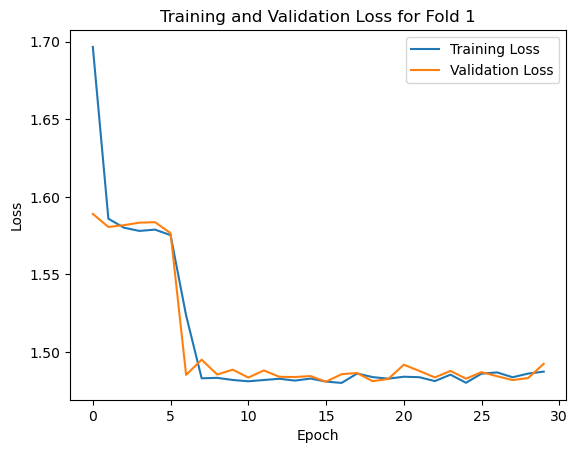

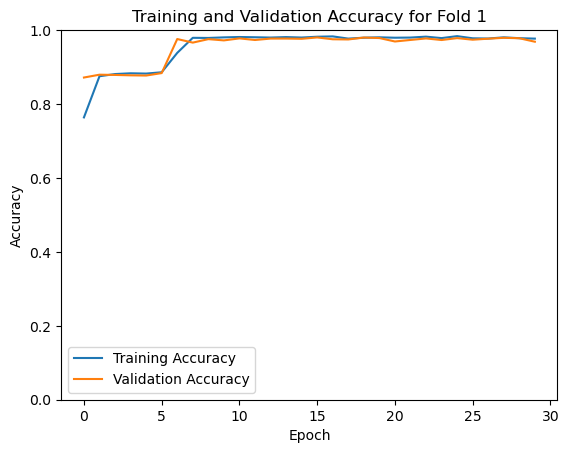

  3%|█▍                                          | 1/30 [00:11<05:33, 11.48s/it]

Epoch 1/30 - Loss: 1.716 - Acc: 0.744
              Val_loss: 1.515 - Val_acc: 0.946


 37%|███████████████▊                           | 11/30 [02:35<04:42, 14.87s/it]

Epoch 11/30 - Loss: 1.486 - Acc: 0.976
              Val_loss: 1.486 - Val_acc: 0.975


 70%|██████████████████████████████             | 21/30 [04:44<01:56, 12.95s/it]

Epoch 21/30 - Loss: 1.489 - Acc: 0.975
              Val_loss: 1.482 - Val_acc: 0.979


func:'train'  took: 388.4302 sec
Epoch with lowest validation loss: 14
Epoch with highest validation accuracy: 14


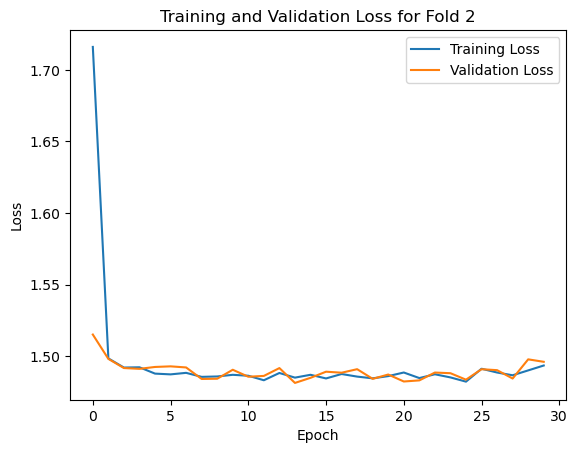

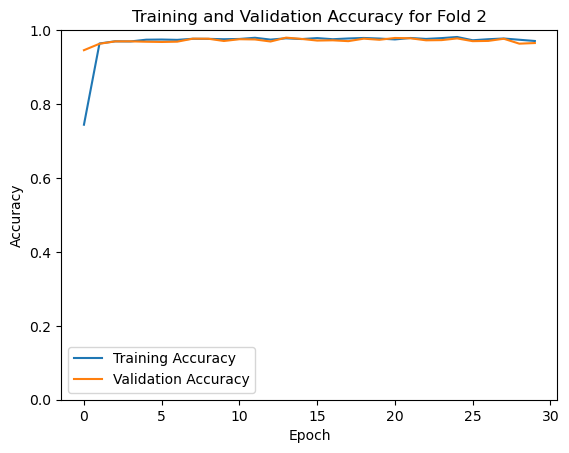

  3%|█▍                                          | 1/30 [00:11<05:27, 11.30s/it]

Epoch 1/30 - Loss: 1.856 - Acc: 0.603
              Val_loss: 1.778 - Val_acc: 0.680


 37%|███████████████▊                           | 11/30 [02:23<04:38, 14.64s/it]

Epoch 11/30 - Loss: 1.481 - Acc: 0.982
              Val_loss: 1.488 - Val_acc: 0.973


 70%|██████████████████████████████             | 21/30 [04:36<01:53, 12.56s/it]

Epoch 21/30 - Loss: 1.478 - Acc: 0.986
              Val_loss: 1.479 - Val_acc: 0.982


func:'train'  took: 383.0872 sec
Epoch with lowest validation loss: 21
Epoch with highest validation accuracy: 21


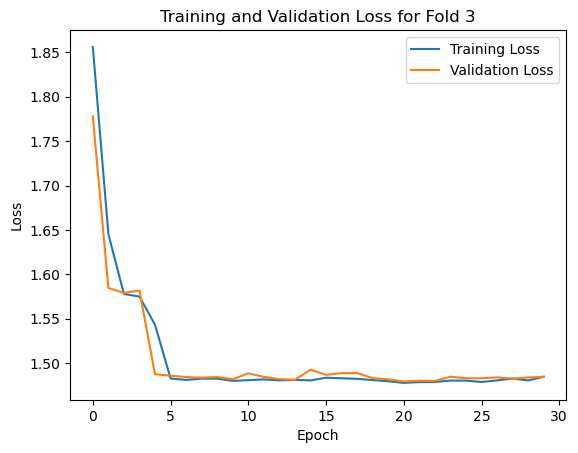

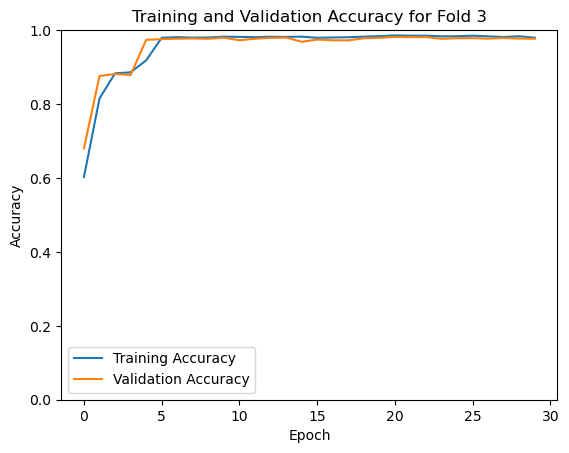

Average training accuracy: 0.976
Average testing accuracy: 0.970


In [10]:
Kfold(3, training_data, training_labels)